# Fig 2

Monogenic resistance can give low doses better sometimes

Partial resistance type X (asymptote one)

NB check that current form for data etc is most up to date fit!!

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [2]:
import pandas as pd

import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from xgboost import XGBRegressor
import shap


from plots2.fns import (
    standard_layout,
    corner_annotations_colwise,
    corner_annotations_rowwise,
    get_text_annotation
)

from poly2.utils import get_dispersal_kernel, trait_vec, beta_dist, gamma_dist
from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote

/Users/nicktaylor/opt/miniconda3/envs/poly2/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
sns.set_palette("viridis", n_colors=4)

In [17]:
# cf = Config(
#     verbose=False, 
#     n_k=101,
#     # n_years=200,
#     n_years=15,
# )

cf = get_asymptote_config(
    verbose=False,
    n_k=101,
    n_years=15,
)

cf.mutation_proportion = 0
cf.mutation_scale_fung = 1
cf.mutation_scale_host = 1

cf.curvature = 5

cf.print_repr()

CONFIG
------
I0s = [0.00985703, 0.00985703, 0.00985703, 0.00985 ...
asymptote = None
betas = [0.00786542, 0.00786542, 0.00786542, 0.007 ...
curvature = 5
decay_rate = None
doses = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1 ...
fungicide_mixture = False
k_b = 0.5
k_mu = 0.99
mutation_proportion = 0
mutation_scale_fung = 1
mutation_scale_host = 1
n_k = 101
n_years = 15
sprays = None



In [18]:
def get_mono_data_asymptote(init_dist):
    doses = np.linspace(0,1,5)[1:]

    df = pd.DataFrame()

    for dd in doses:
        cf.doses = dd*np.ones(cf.n_years)

        sim = SimulatorAsymptote(cf)

        sim.initial_k_dist = init_dist

        data = sim.run_model()

        tmp = pd.DataFrame(
            dict(
                yld=data['yield_vec'],
                dose=dd,
                year=data['year'],
            ))

        df = pd.concat([df, tmp])

    df = df.reset_index(drop=True)
    
    return df

In [19]:
pr = 1e-3

In [20]:
init_dist_1 = np.zeros(cf.n_k)
init_dist_1[0] = pr
init_dist_1[-1] = 1-pr

df_lo = get_mono_data_asymptote(init_dist_1)

In [21]:
init_dist_2 = np.zeros(cf.n_k)
init_dist_2[20] = pr
init_dist_2[-20] = 1-pr

df_hi = get_mono_data_asymptote(init_dist_2)

In [26]:
init_dist_3 = np.zeros(cf.n_k)
init_dist_3[51] = pr
init_dist_3[81] = 1-pr

df_ex = get_mono_data_asymptote(init_dist_3)

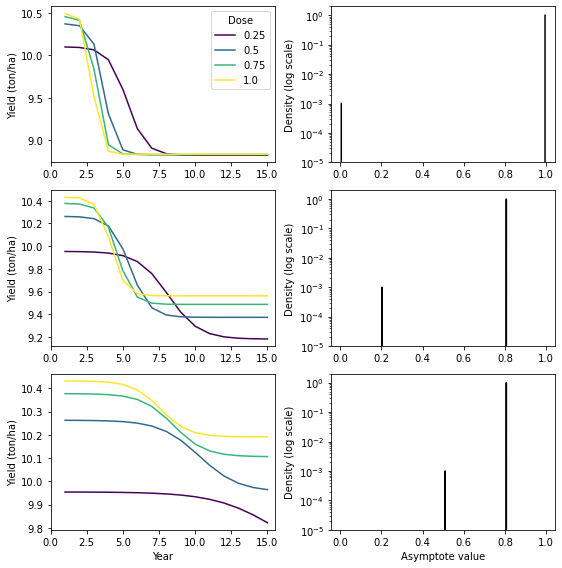

In [27]:
f, ax = plt.subplots(3, 2, figsize=(8,8))

tv = trait_vec(cf.n_k)

sns.lineplot(
    x='year',
    y='yld',
    hue='dose',
    data=df_lo,
    ax=ax[0][0],
    palette='viridis',
)

sns.lineplot(
    x='year',
    y='yld',
    hue='dose',
    data=df_hi,
    ax=ax[1][0],
    palette='viridis',
    legend=False,
)

sns.lineplot(
    x='year',
    y='yld',
    hue='dose',
    data=df_ex,
    ax=ax[2][0],
    palette='viridis',
    legend=False,
)

ax[0][0].legend(title='Dose')

ax[0][1].plot(tv, init_dist_1, c='k')
ax[1][1].plot(tv, init_dist_2, c='k')
ax[2][1].plot(tv, init_dist_3, c='k')

ax[0][1].set_yscale('log')
ax[1][1].set_yscale('log')
ax[2][1].set_yscale('log')

ax[0][0].set_xlim([0,15.5])
ax[1][0].set_xlim([0,15.5])
ax[2][0].set_xlim([0,15.5])

ax[0][1].set_ylim([1e-5, 2])
ax[1][1].set_ylim([1e-5, 2])
ax[2][1].set_ylim([1e-5, 2])

ax[2][0].set_xlabel('Year')
ax[2][1].set_xlabel('Asymptote value')

ax[0][0].set_xlabel(None)
ax[1][0].set_xlabel(None)

ax[0][0].set_ylabel('Yield (ton/ha)')
ax[1][0].set_ylabel('Yield (ton/ha)')
ax[2][0].set_ylabel('Yield (ton/ha)')

ax[0][1].set_ylabel('Density (log scale)')
ax[1][1].set_ylabel('Density (log scale)')
ax[2][1].set_ylabel('Density (log scale)')

plt.tight_layout()

In [29]:
f.savefig('../figures/paper/fig2.jpg')